Plot the increase in magnetisation relative to the uniform baseline for different Ising influence strategies.

Created on 27/09/20

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib
import pylab
import itertools

In [2]:
eval_data = pd.read_csv('Data/Pokec_control_eval_data_new.csv')
eval_data

,Unnamed: 0,control,magnetisation,mag_se,beta_factor,gradient
0,0,no con,-0.610197,0.000017,8.0,1.0
1,1,unif,-0.586741,0.000016,8.0,1.0
2,2,full,-0.557144,0.000007,8.0,1.0
3,3,block,-0.580972,0.000007,8.0,1.0
4,4,sv,-0.588525,0.000039,8.0,1.0
...,...,...,...,...,...,...
1045,2,full,-0.138328,0.000017,8.0,10.0
1046,3,block,-0.174558,0.000015,8.0,10.0
1047,4,sv,-0.169854,0.000005,8.0,10.0
1048,5,nc,-0.171295,0.000007,8.0,10.0


In [3]:
control_names = ['block','full','nc','sv','snapshot']

In [4]:
beta_choice = 8.0
eval_data = eval_data.loc[eval_data['beta_factor']==beta_choice]
eval_data['Sample_index'] = eval_data.reset_index().reset_index().groupby(by=['control','gradient','beta_factor'])['level_0'].transform(lambda x: x.rank())

pivotted = pd.pivot_table( eval_data , values=['magnetisation'],columns=['control'] ,index=['beta_factor','gradient','Sample_index'],aggfunc={'magnetisation':np.mean} ).reset_index()
pivotted.columns=pivotted.columns.map('_'.join)
for k in control_names :
    pivotted[f"markup_{k}"] = pivotted[f'magnetisation_{k}'] - pivotted['magnetisation_unif']

grouped = pivotted.groupby(['beta_factor_','gradient_']).agg({f'markup_{k}':[np.mean,stats.sem] for k in control_names}).reset_index()
grouped.columns=grouped.columns.map('_'.join)
grouped.head()

,beta_factor__,gradient__,markup_block_mean,markup_block_sem,markup_full_mean,markup_full_sem,markup_nc_mean,markup_nc_sem,markup_sv_mean,markup_sv_sem,markup_snapshot_mean,markup_snapshot_sem
0,8.0,1.0,0.007766,0.001419,0.020806,0.001670,-0.010165,0.001891,-0.006767,0.001515,0.002395,0.001572
1,8.0,2.0,0.013077,0.002090,0.020693,0.001676,-0.009993,0.002474,-0.007215,0.002386,0.005381,0.002729
2,8.0,3.0,0.006354,0.001835,0.025443,0.001358,-0.010788,0.001570,-0.000897,0.001479,0.002622,0.001312
3,8.0,4.0,0.001141,0.001972,0.024608,0.001570,-0.007284,0.001892,-0.000321,0.001501,0.000284,0.001530
4,8.0,5.0,0.002561,0.001775,0.026675,0.001464,-0.004904,0.001469,0.003935,0.001213,0.000737,0.001576


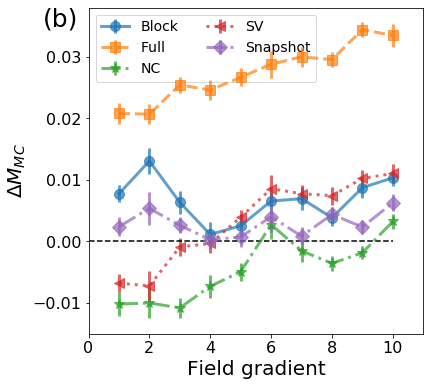

In [5]:
gradient = list(grouped['gradient__'])

# Select colours scheme:
cmap = pylab.cm.get_cmap("tab10", 6)    # PiYG
#hex_codes = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in  range(cmap.N)]
hex_codes  = [matplotlib.colors.rgb2hex(pal) for pal in  sns.color_palette()]
col= itertools.cycle(tuple(hex_codes))
marker_styles = itertools.cycle(('o','s','*','<',"D","P"))
line_styles = itertools.cycle(('-', '--', '-.', ':','-.'))


def name_map(label) :
    """
    Upper case SV and NC.
    
    .title() to other labels
    """
    if len(label) < 3 :
        return label.upper()
    else :
        return label.title()

fig,ax=plt.subplots(figsize=(6,6))

for con in control_names :
    mean_markup = list(grouped[f'markup_{con}_mean'])
    sem_markup = list(grouped[f'markup_{con}_sem'])
    col_current=next(col)
    plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                 ,mfc=f'{col_current}',mec=f'{col_current}',
                 color=f'{col_current}',
                 marker=f'{next(marker_styles)}',
                linestyle=f'{next(line_styles)}',alpha=0.7,markersize=10,lw=3.0)

plt.plot([0,10],[0,0],'k--')

plt.xlabel("Field gradient",fontsize=20)
plt.ylabel("$\Delta M_{MC}$",fontsize=20 )
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.legend(fontsize=14,ncol=2,loc='upper left')
ax.legend(fontsize=14,ncol=2,loc='upper left').set_zorder(0)
plt.xlim(0,11)
plt.ylim(-0.015,0.038)

plt.text(-1.5,0.035,'(b)',fontsize=25)

plt.savefig(f"Plots/Pokec_markup_as_grad_beta_{beta_choice}_errors".replace('.','-') + ".jpg",bbox_inches='tight')